In [151]:
import keras

In [152]:
model = keras.models.load_model('LSTM.h5')

In [153]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 128)          71680     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 120, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 120, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [154]:
import pandas as pd

In [155]:
smog = pd.read_excel('Smog.xlsx')
smog.drop(columns='Unnamed: 0', axis=1, inplace=True)
smog['Data'] = smog['Data'].dt.round('H')

In [156]:
smog.set_index('Data', inplace=True)
smog.head()

,Dwutlenek_azotu,Tlenki_azotu,PM10,PM_2_5,Benzen,Tlenek_wegla,Kierunek_wiatru,Predkosc_wiatru,Temperatura,Wilgotnosc,Cisnienie
Data,,,,,,,,,,,
2020-01-01 01:00:00,19.7,35.0,34.3,17.9,0.2,0.7,278.0,2.471667,4.403333,62.058333,1002.798333
2020-01-01 02:00:00,22.8,43.5,32.2,15.0,0.2,0.7,279.0,2.200000,4.113333,61.336667,1002.940000
2020-01-01 03:00:00,31.8,68.4,35.7,16.3,0.2,0.8,270.0,1.906667,3.830000,62.410000,1003.261667
2020-01-01 04:00:00,26.4,52.6,34.0,15.0,0.2,0.7,278.0,1.998333,3.480000,63.541667,1003.481667
2020-01-01 05:00:00,24.5,50.4,26.1,11.6,0.2,0.7,277.0,2.248333,3.135000,64.786667,1003.888333


In [157]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
smog_scaled = scaler.fit_transform(smog)
smog_scaled

array([[0.0939759 , 0.03747047, 0.12759886, ..., 0.2760262 , 0.69524971,
        0.74684205],
       [0.1126506 , 0.04659652, 0.11903791, ..., 0.26842795, 0.68581883,
        0.74925119],
       [0.16686747, 0.07333047, 0.13330616, ..., 0.26100437, 0.69984536,
        0.75472135],
       ...,
       [0.21204819, 0.08975735, 0.18263351, ..., 0.207046  , 0.84753697,
        0.47648431],
       [0.22409639, 0.1140219 , 0.20179372, ..., 0.20516025, 0.84911666,
        0.47513097],
       [0.21204819, 0.09780975, 0.25968202, ..., 0.20139145, 0.8541656 ,
        0.4727706 ]])

In [158]:
smog_scaled.shape

(8771, 11)

In [159]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [160]:
days_to_predict = 30
num_hours = 24 * days_to_predict
smog_input = smog_scaled[-(num_hours + 120):]
smog_input.shape

(840, 11)

In [161]:
win_length = 120    #ostatnie 5 dni
batch_size = 32     #32 serie do uczenia
num_features = 11   #liczba features do uczenia

predict_generator = TimeseriesGenerator(smog_input, 
                                        smog_input, 
                                        length=win_length, 
                                        sampling_rate=1, 
                                        batch_size=batch_size)

In [162]:
predictions = model.predict_generator(predict_generator)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [163]:
predictions.shape

(720, 11)

In [164]:
smog_out = pd.DataFrame(predictions)
smog_out.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.204088,0.172826,0.218043,0.178279,0.081418,0.012016,0.301878,0.141761,0.143057,0.866260,0.554574
1,0.175282,0.163272,0.232673,0.194015,0.084746,0.012403,0.255227,0.142922,0.130691,0.871663,0.552221
2,0.109467,0.121710,0.221634,0.190595,0.077766,0.012265,0.232421,0.193826,0.123286,0.876803,0.556711
3,0.069669,0.097050,0.216372,0.190739,0.075396,0.012056,0.254378,0.205090,0.115204,0.886487,0.560302
4,0.085594,0.112442,0.227233,0.198777,0.080461,0.012001,0.305318,0.191481,0.117664,0.882534,0.566299


In [165]:
smog_out_rev = scaler.inverse_transform(smog_out)
smog_out_rev

array([[ 3.79786415e+01,  1.61070587e+02,  5.64859581e+01, ...,
        -6.71649158e-01,  7.51443253e+01,  9.91492249e+02],
       [ 3.31968460e+01,  1.52171265e+02,  6.00747871e+01, ...,
        -1.14362264e+00,  7.55577698e+01,  9.91353821e+02],
       [ 2.22715645e+01,  1.13460358e+02,  5.73668251e+01, ...,
        -1.42625749e+00,  7.59510651e+01,  9.91617859e+02],
       ...,
       [ 3.34397545e+01,  1.15241356e+02,  3.61352234e+01, ...,
         3.54394913e+00,  7.59403076e+01,  9.86658752e+02],
       [ 2.89056129e+01,  9.90085068e+01,  3.47080307e+01, ...,
         3.41391516e+00,  7.61139984e+01,  9.86681396e+02],
       [ 3.12950802e+01,  1.12799171e+02,  3.60252647e+01, ...,
         3.40888882e+00,  7.53111725e+01,  9.86718872e+02]], dtype=float32)

In [166]:
smog_last_month = smog[predictions.shape[0]*-1:]

In [167]:
smog_last_month.tail()

,Dwutlenek_azotu,Tlenki_azotu,PM10,PM_2_5,Benzen,Tlenek_wegla,Kierunek_wiatru,Predkosc_wiatru,Temperatura,Wilgotnosc,Cisnienie
Data,,,,,,,,,,,
2020-12-31 19:00:00,44.8,162.2,52.3,28.9,2.4,1.1,159.517241,1.351681,1.893145,73.365169,986.882812
2020-12-31 20:00:00,39.5,108.1,52.6,30.1,2.7,0.9,157.310345,1.428841,1.842346,73.492614,986.892811
2020-12-31 21:00:00,39.3,83.7,47.8,27.3,1.8,0.8,173.034483,1.409485,1.770589,73.711608,986.900253
2020-12-31 22:00:00,41.3,106.3,52.5,31.2,1.8,0.9,142.137931,1.406695,1.698616,73.832488,986.820671
2020-12-31 23:00:00,39.3,91.2,66.7,41.9,3.4,1.1,160.896552,1.437244,1.554774,74.218842,986.681872


In [168]:
import datetime

In [169]:
base = smog_last_month.index[-1]
date_list = [base + datetime.timedelta(hours=x+1) for x in range(num_hours)]

In [170]:
predictions_df = pd.DataFrame(smog_out_rev)

In [171]:
predictions_df['Data'] = date_list

In [172]:
predictions_df.set_index('Data', inplace=True)

In [173]:
predictions_df.columns = list(smog_last_month.columns)

In [174]:
smog_final_out = smog_last_month.append(predictions_df)
smog_final_out.head()

,Dwutlenek_azotu,Tlenki_azotu,PM10,PM_2_5,Benzen,Tlenek_wegla,Kierunek_wiatru,Predkosc_wiatru,Temperatura,Wilgotnosc,Cisnienie
Data,,,,,,,,,,,
2020-12-02 00:00:00,43.0,235.2,75.7,65.4,5.7,1.5,56.0,1.690000,-3.768333,76.005000,996.551667
2020-12-02 01:00:00,33.2,150.2,74.6,65.2,5.3,1.2,66.0,2.163333,-3.783333,77.528333,996.560000
2020-12-02 02:00:00,30.2,70.7,85.8,75.4,6.0,1.0,84.0,2.085000,-3.993333,78.700000,996.598333
2020-12-02 03:00:00,29.4,57.9,86.9,76.9,6.4,1.0,106.0,1.916667,-4.096667,78.890000,996.645000
2020-12-02 04:00:00,28.6,50.9,83.4,73.8,5.7,0.9,90.0,1.683333,-3.900000,76.931667,996.840000


In [177]:
import matplotlib.pyplot as plt

def print_results(num_hours, dataframe=smog_final_out):
    
    columns = list(dataframe.columns)
    
    for column in columns:
        plt.figure(figsize=(8, 8))
        plt.plot(dataframe[column][:num_hours+1])
        plt.plot(dataframe[column][num_hours:])
        plt.xlabel('Data')
        plt.ylabel(column)
        plt.title(f'Predykcja {column}')
        plt.grid()
        plt.show()

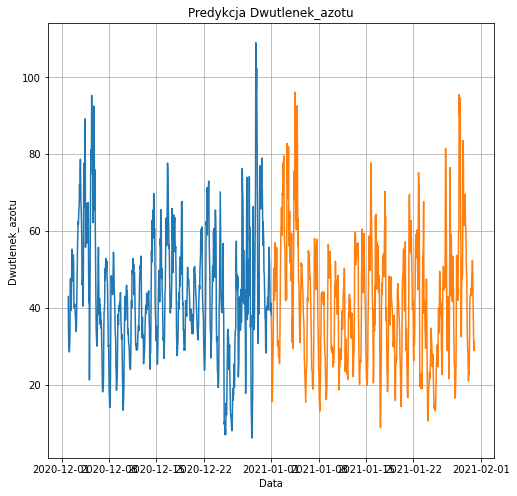

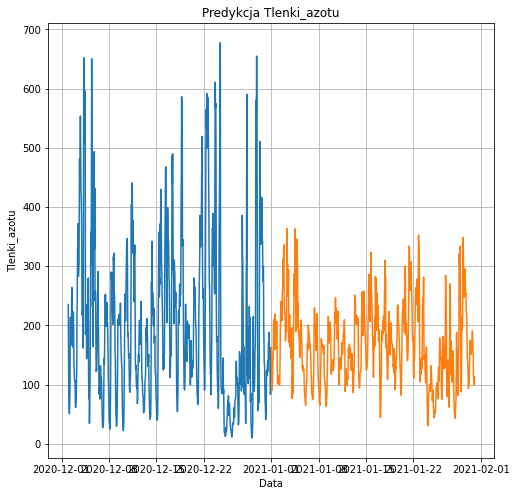

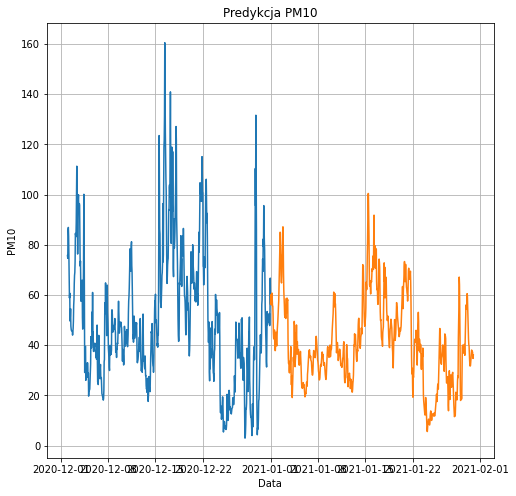

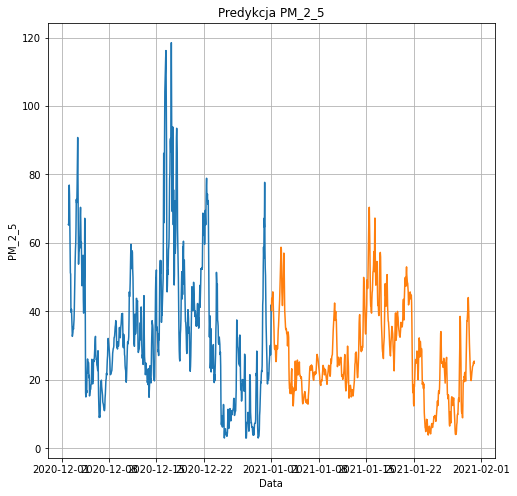

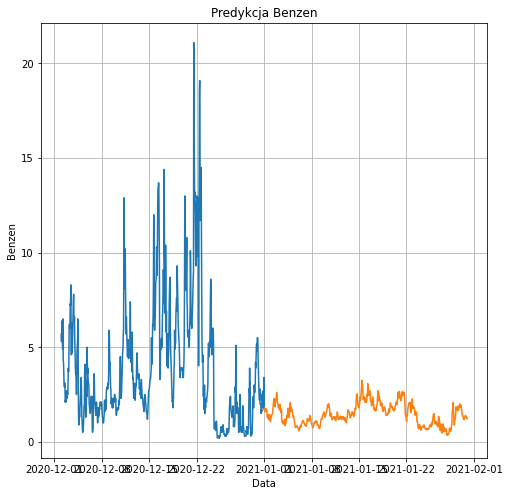

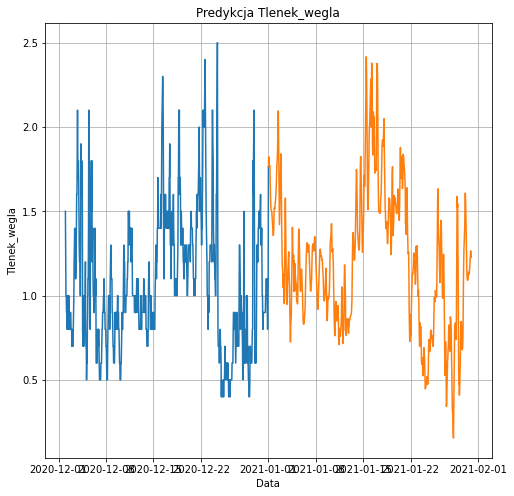

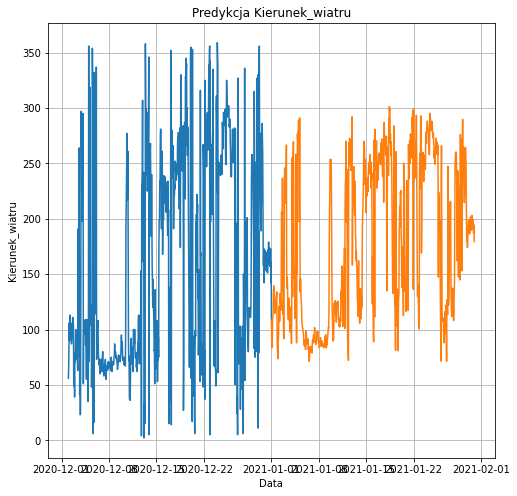

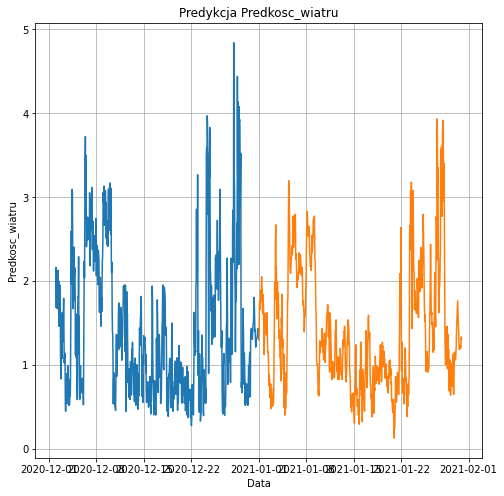

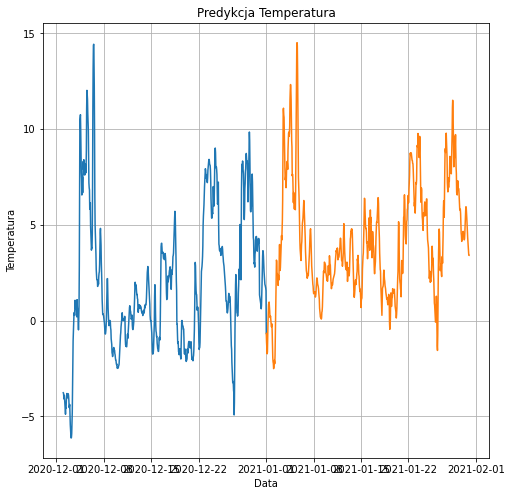

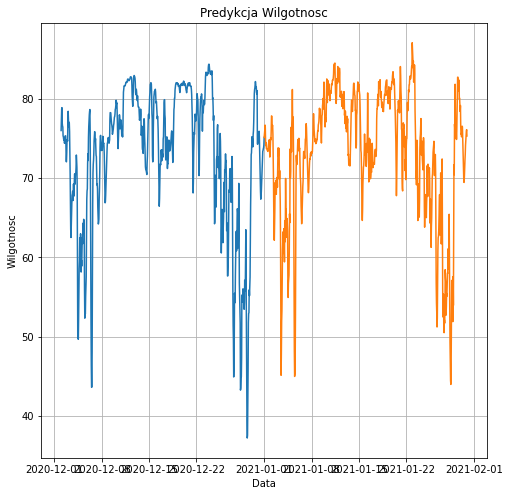

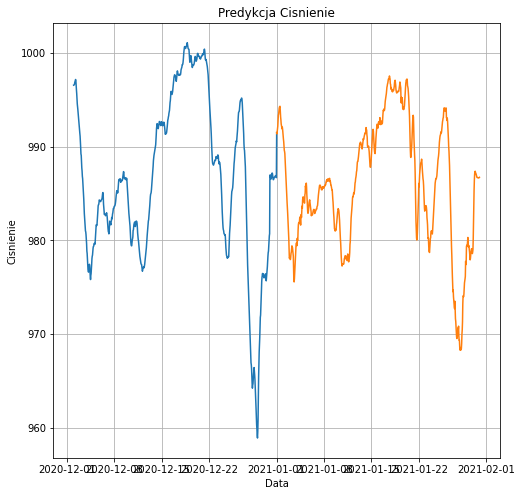

In [178]:
print_results(num_hours)

In [181]:
smog_final_out['PM_2_5'].tail(24)

Data
2021-01-30 00:00:00    40.194756
2021-01-30 01:00:00    43.801579
2021-01-30 02:00:00    44.036407
2021-01-30 03:00:00    41.265823
2021-01-30 04:00:00    38.453926
2021-01-30 05:00:00    34.294731
2021-01-30 06:00:00    30.754591
2021-01-30 07:00:00    27.994980
2021-01-30 08:00:00    25.885965
2021-01-30 09:00:00    23.238813
2021-01-30 10:00:00    21.223724
2021-01-30 11:00:00    19.913490
2021-01-30 12:00:00    19.777145
2021-01-30 13:00:00    20.387152
2021-01-30 14:00:00    21.485691
2021-01-30 15:00:00    22.385637
2021-01-30 16:00:00    22.957512
2021-01-30 17:00:00    23.921276
2021-01-30 18:00:00    24.082949
2021-01-30 19:00:00    24.153414
2021-01-30 20:00:00    25.043194
2021-01-30 21:00:00    25.189125
2021-01-30 22:00:00    24.734354
2021-01-30 23:00:00    25.424044
Name: PM_2_5, dtype: float64